In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
df_events = pd.read_parquet('data/add_event.parquet')
df_offers = pd.read_parquet('data/offer_metadata.parquet')
df_train = pd.read_parquet('data/train_data.parquet')
df_test = pd.read_parquet('data/test_data.parquet')
df_dict = pd.read_csv('data/data_dictionary.csv')

In [3]:
df_events.head()

,id2,id3,id6,id4,id7
0,2431360,618619,Tiles,2023-10-22 08:08:17.768,None
1,2431360,363153,Tiles,2023-10-22 08:08:18.921,None
2,2431360,97193,Tiles,2023-10-22 08:08:17.765,None
3,2431360,654444,Tiles,2023-10-22 08:08:17.737,None
4,2431360,32325,Tiles,2023-10-22 08:08:17.812,None


In [4]:
df_train['id4'] = pd.to_datetime(df_train['id4'])
df_test['id4'] = pd.to_datetime(df_test['id4'])
df_train['id5'] = pd.to_datetime(df_train['id5'])
df_test['id5'] = pd.to_datetime(df_test['id5'])
df_offers['id12'] = pd.to_datetime(df_offers['id12'])
df_offers['id13'] = pd.to_datetime(df_offers['id13'])
df_train['id3'] = df_train['id3'].astype(str)
df_test['id3'] = df_test['id3'].astype(str)
df_offers['id3'] = df_offers['id3'].astype(str)

In [5]:
# -----------------------------
# 3. Merge Offer Metadata + is_offer_active + CTR
# -----------------------------
df_train = df_train.merge(df_offers[['id3', 'id12', 'id13']], on='id3', how='left')
df_test = df_test.merge(df_offers[['id3', 'id12', 'id13']], on='id3', how='left')

df_train['is_offer_active'] = ((df_train['id4'] >= df_train['id12']) & (df_train['id4'] <= df_train['id13'])).astype(int)
df_test['is_offer_active'] = ((df_test['id4'] >= df_test['id12']) & (df_test['id4'] <= df_test['id13'])).astype(int)

df_train.drop(columns=['id12', 'id13'], inplace=True)
df_test.drop(columns=['id12', 'id13'], inplace=True)

# CTR Engineering as before...

In [6]:
df_train.drop(columns=['id4', 'id5'], inplace=True)

In [7]:

# CTR Engineering
df_events['is_clicked'] = df_events['id7'].notna().astype(int)
offer_ctr = df_events.groupby('id3').agg(impressions=('id4', 'count'), clicks=('is_clicked', 'sum')).reset_index()
offer_ctr['ctr'] = offer_ctr['clicks'] / offer_ctr['impressions']
df_offers = df_offers.merge(offer_ctr, on='id3', how='left')


In [8]:
clicks_only = df_events[df_events['is_clicked'] == 1].copy()
df_events['id4'] = pd.to_datetime(df_events['id4'])
clicks_only['id4'] = pd.to_datetime(clicks_only['id4'])
cutoff_7d = df_events['id4'].max() - pd.Timedelta(days=7)
recent_clicks = clicks_only[clicks_only['id4'] >= cutoff_7d]
click_momentum = recent_clicks.groupby('id2').agg(click_momentum_7d=('id4', 'count')).reset_index()
df_train['id2'] = df_train['id2'].astype(str)
click_momentum['id2'] = click_momentum['id2'].astype(str)
df_train = df_train.merge(click_momentum, on='id2', how='left')
df_train['click_momentum_7d'].fillna(0, inplace=True)

C:\Users\91820\AppData\Local\Temp\ipykernel_20300\3357228718.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['click_momentum_7d'].fillna(0, inplace=True)


In [9]:
# Final CTR Features
df_offers_final = df_offers[['id3', 'ctr', 'impressions', 'clicks']]
df_train = df_train.merge(df_offers_final, on='id3', how='left')
df_test = df_test.merge(df_offers_final, on='id3', how='left')
for col in ['ctr', 'impressions', 'clicks']:
    df_train[col] = df_train[col].fillna(0)
    df_test[col] = df_test[col].fillna(0)

In [10]:
f_cols = [f"f{i}" for i in range(1, 367)]
numerical_features = df_dict[df_dict['Type'] == 'Numerical']['masked_column'].tolist()
categorical_features = df_dict[df_dict['Type'].isin(['Categorical', 'One hot encoded'])]['masked_column'].tolist()
categorical_features = [col for col in categorical_features if col in df_train.columns and col != 'id3']

# Keep only valid features
numerical_features = [col for col in numerical_features if col in df_train.columns]

In [11]:
# Combine numeric + categorical for drop check
X = pd.concat([df_train[numerical_features], df_train[categorical_features]], axis=1)
X_test = pd.concat([df_test[numerical_features], df_test[categorical_features]], axis=1)

cols_to_drop = []
for col in X.columns:
    unique_vals = X[col].dropna().unique()
    nunique = len(unique_vals)
    if nunique == 1 or set(unique_vals).issubset({0.0}):
        cols_to_drop.append(col)
        print(f"Dropping column: {col} | Unique values: {unique_vals}")

print(f"Dropping {len(cols_to_drop)} columns.")

# Drop in df_train and df_test too
numerical_features = [col for col in numerical_features if col not in cols_to_drop]
categorical_features = [col for col in categorical_features if col not in cols_to_drop]

Dropping column: f14 | Unique values: ['0.0']
Dropping column: f15 | Unique values: ['0.0']
Dropping column: f16 | Unique values: ['0.0']
Dropping column: f17 | Unique values: ['0.0']
Dropping column: f19 | Unique values: ['0.0']
Dropping column: f20 | Unique values: ['0.0']
Dropping column: f21 | Unique values: ['0.0']
Dropping column: f23 | Unique values: ['0.0']
Dropping column: f24 | Unique values: ['0.0']
Dropping column: f25 | Unique values: ['0.0']
Dropping column: f62 | Unique values: ['0.0']
Dropping column: f66 | Unique values: ['0.0']
Dropping column: f80 | Unique values: ['0.0']
Dropping column: f88 | Unique values: ['0.0']
Dropping column: f102 | Unique values: ['0.0']
Dropping column: f112 | Unique values: []
Dropping column: f122 | Unique values: []
Dropping column: f128 | Unique values: ['0.0']
Dropping column: f129 | Unique values: ['0.0']
Dropping column: f135 | Unique values: []
Dropping column: f136 | Unique values: []
Dropping column: f144 | Unique values: ['0.0']


In [12]:
num_imputer = SimpleImputer(strategy='median')
df_train[numerical_features] = num_imputer.fit_transform(df_train[numerical_features])
df_test[numerical_features] = num_imputer.transform(df_test[numerical_features])

cat_imputer = SimpleImputer(strategy='most_frequent')
df_train[categorical_features] = cat_imputer.fit_transform(df_train[categorical_features])
df_test[categorical_features] = cat_imputer.transform(df_test[categorical_features])

In [13]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_train[categorical_features] = encoder.fit_transform(df_train[categorical_features].astype(str))
df_test[categorical_features] = encoder.transform(df_test[categorical_features].astype(str))

In [14]:
X_train = pd.concat([
    df_train[numerical_features],
    pd.DataFrame(df_train[categorical_features], columns=categorical_features, index=df_train.index)
], axis=1)

X_test = pd.concat([
    df_test[numerical_features],
    pd.DataFrame(df_test[categorical_features], columns=categorical_features, index=df_test.index)
], axis=1)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. PCA
pca = PCA(n_components=20, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 5. KMeans clustering
kmeans = KMeans(n_clusters=7, random_state=42, n_init='auto')
df_train['customer_cluster'] = kmeans.fit_predict(X_train_pca)
df_test['customer_cluster'] = kmeans.predict(X_test_pca)

C:\Users\91820\AppData\Local\Temp\ipykernel_20300\3631020755.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['customer_cluster'] = kmeans.fit_predict(X_train_pca)
C:\Users\91820\AppData\Local\Temp\ipykernel_20300\3631020755.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['customer_cluster'] = kmeans.predict(X_test_pca)


In [16]:
for col in df_train.select_dtypes(include=['float64']).columns:
    df_train[col] = df_train[col].astype('float32')
    if col in df_test.columns:
        df_test[col] = df_test[col].astype('float32')

In [17]:
df_train.head()

,id1,id2,id3,y,f1,f2,f3,f4,f5,f6,...,f363,f364,f365,f366,is_offer_active,click_momentum_7d,ctr,impressions,clicks,customer_cluster
0,1366776_189706075_16-23_2023-11-02 22:22:00.042,1366776,189706075,0,1.0,31.0,31.0,40.0,34.0,36.0,...,0.00000,337.0,0.0,0.00000,1,0.0,0.059875,18238.0,1092.0,5
1,1366776_89227_16-23_2023-11-01 23:51:24.999,1366776,89227,0,1.0,31.0,31.0,40.0,34.0,36.0,...,0.00000,1010.0,2.0,0.00198,1,0.0,0.046487,20780.0,966.0,5
2,1366776_35046_16-23_2023-11-01 00:30:59.797,1366776,35046,0,1.0,31.0,31.0,40.0,34.0,36.0,...,0.00000,1010.0,2.0,0.00198,1,0.0,0.041484,18296.0,759.0,5
3,1366776_6275451_16-23_2023-11-02 22:21:32.261,1366776,6275451,0,1.0,31.0,31.0,40.0,34.0,36.0,...,0.00361,337.0,0.0,0.00000,1,0.0,0.042805,18012.0,771.0,5
4,1366776_78053_16-23_2023-11-02 22:21:34.799,1366776,78053,0,1.0,31.0,31.0,40.0,34.0,36.0,...,0.00000,337.0,0.0,0.00000,1,0.0,0.042544,18428.0,784.0,5


In [18]:
df_train2 = df_train.copy()

In [93]:
df_train = df_train2

In [94]:
for col in categorical_features:
    if col in df_train.columns:
        df_train[col] = df_train[col].astype('category')
    if col in df_test.columns:
        df_test[col] = df_test[col].astype('category')

In [95]:
# Convert all object dtype columns in df_train and df_test to float32 if possible
for df in [df_train, df_test]:
    obj_cols = df.select_dtypes(include=['object']).columns
    for col in obj_cols:
        try:
            df[col] = pd.to_numeric(df[col], errors='raise').astype('float32')
        except Exception:
            print(f"Error in col: {col}")
            pass  # Skip columns that cannot be converted

Error in col: id1
Error in col: id1


In [72]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# 1) Filter to valid customers
def filter_valid(df, gid='id2', label='y', min_offers=2):
    grp = df.groupby(gid)
    valid = grp.filter(lambda g: g[label].sum()>0 and len(g)>=min_offers)[gid].unique()
    return df[df[gid].isin(valid)].reset_index(drop=True)

df_train = filter_valid(df_train, 'id2', 'y', 2)

# 2) Split by customer
df_train = df_train.sort_values('id2').reset_index(drop=True)
custs = df_train['id2'].unique()
np.random.seed(42)
np.random.shuffle(custs)
cut = int(len(custs)*0.2)
val_c, trn_c = custs[:cut], custs[cut:]

df_tr = df_train[df_train['id2'].isin(trn_c)].copy()
df_va = df_train[df_train['id2'].isin(val_c)].copy()

# 3) Build feature list
drop_cols = ['id1','id2','id3','id5','y']
features = [c for c in df_train.columns if c not in drop_cols]

X_tr, y_tr = df_tr[features], df_tr['y']
X_va, y_va = df_va[features], df_va['y']
group_tr = df_tr.groupby('id2').size().tolist()
group_va = df_va.groupby('id2').size().tolist()

dtrain = lgb.Dataset(X_tr, label=y_tr, group=group_tr, categorical_feature='auto')
dvalid = lgb.Dataset(X_va, label=y_va, group=group_va, categorical_feature='auto')


In [96]:

# 4) Train lambdarank
params = {
    'objective':'lambdarank','metric':'map','eval_at':[7],
    'boosting_type':'gbdt','learning_rate':0.048,'num_leaves':64,
    'feature_fraction':0.8,'bagging_fraction':0.8,'bagging_freq':5,
    'device_type':'gpu','gpu_platform_id':1,'gpu_device_id':0,
    'random_state':44,'verbosity':1
}

model = lgb.train(
    params, dtrain,
    valid_sets=[dtrain,dvalid],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(50)]
)

# 5) Quick val MAP@7
def apk(a,p,k=7):
    p=p[:k]; score=hits=0.0
    for i,pi in enumerate(p):
        if pi in a and pi not in p[:i]:
            hits+=1; score+=hits/(i+1)
    return score/min(len(a),k) if a else 0.0

def map7(df, pr='pred'):
    out=[]
    for cid,grp in df.groupby('id2'):
        act = grp[grp['y']==1]['id3'].tolist()
        prd = grp.sort_values(pr,ascending=False)['id3'].tolist()
        out.append(apk(act,prd,7))
    return np.mean(out)

df_va['pred'] = model.predict(X_va, num_iteration=model.best_iteration)
print("Validation MAP@7:", map7(df_va))

[LightGBM] [Info] Total groups: 3958, total data: 346405
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 45583
[LightGBM] [Info] Number of data points in the train set: 346405, number of used features: 317
[LightGBM] [Info] Using requested OpenCL platform 1 device 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 173 dense feature groups (58.14 MB) transferred to GPU in 0.065713 secs. 1 sparse feature groups
[LightGBM] [Info] Total groups: 989, total data: 82566
Training until validation scores don't improve for 100 rounds


: 

# This is older ranking model


In [ ]:
def filter_valid_ranking_groups(df, group_col='id2', label_col='y', min_offers=2):
    """
    Keeps only those groups (e.g., customers) that:
    - Have at least one positive click
    - Have at least `min_offers` offers
    """
    # Ensure label column is numeric
    df[label_col] = pd.to_numeric(df[label_col], errors='coerce').fillna(0).astype(int)
    grouped = df.groupby(group_col)
    valid_groups = grouped.filter(
        lambda g: g[label_col].sum() > 0 and len(g) >= min_offers
    )[group_col].unique()

    return df[df[group_col].isin(valid_groups)].reset_index(drop=True)

df_train = filter_valid_ranking_groups(df_train)
df_train.shape

In [87]:
df_train = df_train.sort_values('id2').reset_index(drop=True)

customers = df_train['id2'].unique()
np.random.seed(42)
np.random.shuffle(customers)

val_fraction = 0.2
val_cutoff = int(len(customers) * val_fraction)

val_customers = customers[:val_cutoff]
train_customers = customers[val_cutoff:]

df_train_split = df_train[df_train['id2'].isin(train_customers)].copy()
df_val_split = df_train[df_train['id2'].isin(val_customers)].copy()

In [88]:
common_elements = set(df_train_split['id2']) & set(df_val_split['id2'])
print("✅ Common elements in column 'col':")
print(common_elements)

✅ Common elements in column 'col':
set()


In [89]:
# Drop ID columns and label
drop_cols = ['id1', 'id2','id3','click_momentum_7d' 'y']
feature_cols = [col for col in df_train.columns if col not in drop_cols]

X_train = df_train_split[feature_cols]
y_train = df_train_split['y']
group_train = df_train_split.groupby('id2').size().tolist()

X_val = df_val_split[feature_cols]
y_val = df_val_split['y']
group_val = df_val_split.groupby('id2').size().tolist()

In [90]:
train_data = lgb.Dataset(X_train, label=y_train, group=group_train)
val_data = lgb.Dataset(X_val, label=y_val, group=group_val)

In [91]:
import pyopencl as cl

for i, platform in enumerate(cl.get_platforms()):
    print(f"Platform ID {i}: {platform.name}")
    for j, device in enumerate(platform.get_devices()):
        print(f"  Device ID {j}: {device.name} (Vendor: {device.vendor})")


Platform ID 0: NVIDIA CUDA
  Device ID 0: NVIDIA GeForce RTX 3070 Ti Laptop GPU (Vendor: NVIDIA Corporation)
Platform ID 1: Intel(R) OpenCL Graphics
  Device ID 0: Intel(R) UHD Graphics (Vendor: Intel(R) Corporation)
Platform ID 2: OpenCLOn12
  Device ID 0: Intel(R) UHD Graphics (Vendor: Microsoft)
  Device ID 1: NVIDIA GeForce RTX 3070 Ti Laptop GPU (Vendor: Microsoft)
  Device ID 2: Microsoft Basic Render Driver (Vendor: Microsoft)


In [92]:
params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'boosting_type': 'gbdt',
    'verbosity': 1,
    'random_state': 44,
    'learning_rate': 0.048,
    'num_leaves': 64,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    # 'lambda_l2': 0.02,
    'device_type': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0, 
    # 'max_position': 7,
    'eval_at': [7]
}
params_gpu = params.copy()
# params_gpu['device'] = 'gpu'
params_gpu['gpu_platform_id'] = 0  
params_gpu['gpu_device_id'] = 0  
model = lgb.train(
    params_gpu,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=50)
    ]
)


[LightGBM] [Info] Total groups: 37240, total data: 616615
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 47729
[LightGBM] [Info] Number of data points in the train set: 616615, number of used features: 323
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 167 dense feature groups (98.79 MB) transferred to GPU in 0.113431 secs. 1 sparse feature groups
[LightGBM] [Info] Total groups: 9310, total data: 153549
Training until validation scores don't improve for 100 rounds


LightGBMError: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 852 .


In [83]:
df_val_split['pred'] = model.predict(X_val)


def apk(actual, predicted, k=7):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    hits = 0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            hits += 1
            score += hits / (i + 1.0)
    return score / min(len(actual), k) if actual else 0.0

def mapk(df):
    actual = df[df['y'] == 1].groupby('id2')['id3'].apply(list)
    predicted = df.groupby('id2')['id3'].apply(
        lambda x: df.loc[x.index].sort_values('pred', ascending=False)['id3'].tolist()
    )
    actual = actual.reindex(predicted.index, fill_value=[])
    return np.mean([apk(a, p, k=7) for a, p in zip(actual, predicted)])

map7 = mapk(df_val_split)
print(f"\n📊 Validation MAP@7: {map7:.4f}")


📊 Validation MAP@7: 0.0466


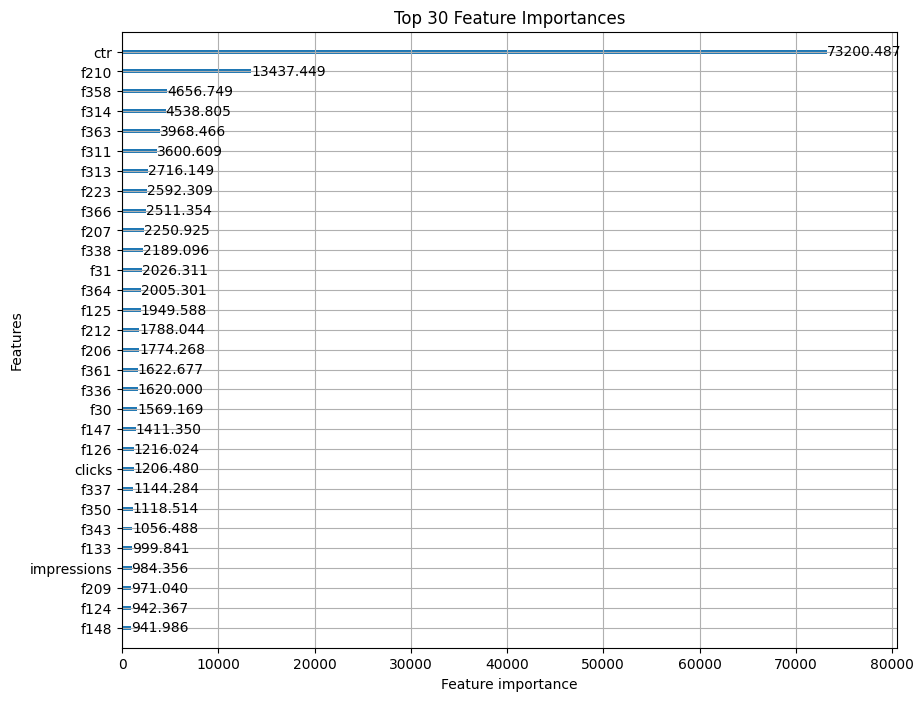

In [84]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Plot feature importance

lgb.plot_importance(model, max_num_features=30, importance_type='gain', figsize=(10, 8))
plt.title("Top 30 Feature Importances")
plt.show()


In [ ]:
X_test = df_test[feature_cols]  # Same `feature_cols` used in training

df_test['click_proba'] = model.predict(X_test, num_iteration=model.best_iteration)
df_test['pred'] = df_test['click_proba']  # Optional renaming

# ------------------------
# Step 3: Format date if needed (id5)
# ------------------------

df_test['id5'] = pd.to_datetime(df_test['id5']).dt.strftime('%-m/%-d/%Y')  # Unix -> M/D/YYYY

# ------------------------
# Step 4: Build submission
# ------------------------

# For MAP@7-style prediction, you often want to sort offers by predicted score per customer
df_test_sorted = (
    df_test
    .sort_values(['id2', 'pred'], ascending=[True, False])  # Sort offers by score within each customer
)

# Optional: if top-7 matters, group and take top 7 per customer
# top7 = df_test_sorted.groupby('id2').head(7)

# Final submission format
submission = df_test_sorted[['id1', 'id2', 'id3', 'id5', 'pred']].reset_index(drop=True)

# ------------------------
# Step 5: Save to CSV
# ------------------------

submission.to_csv('submission.csv', index=False)
print("✅ Submission saved to 'submission.csv'")


KeyError: "['click_momentum_7d'] not in index"